In [1]:
cd ~/Desktop/DeepLearningPilot/

/Users/jz-rolling/Desktop/DeepLearningPilot


In [7]:
import tensorflow as tf,matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize,rescale
from skimage import measure, segmentation,morphology,filters,feature,exposure
import tifffile
import momia2 as mo
from momia2.classify.classifier_helper import *
import timeit
import pickle as pk
from tensorflow import keras
from unet import *
import glob, os
import seaborn as sns
from sklearn.cluster import KMeans,DBSCAN,AgglomerativeClustering
from matplotlib import cm
from matplotlib.gridspec import GridSpec as gs
from microfilm.microplot import microshow

In [3]:
model = tf.keras.models.load_model('/Users/jz-rolling/Desktop/DeepLearningPilot/AttResUnet_20221229_2channel_512/')

2023-01-01 16:15:38.366416: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-01 16:15:39.164156: E tensorflow/core/framework/node_def_util.cc:629] NodeDef mentions attribute validate_shape which is not in the op definition: Op<name=AssignVariableOp; signature=resource:resource, value:dtype -> ; attr=dtype:type; is_stateful=true> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node AssignNewValue}}


In [55]:
for root in sorted(glob.glob('/Volumes/JZSSD_temp/202212_Harry_flow/ClpC1_loc/20190823/*/')):
    for f in sorted(glob.glob(root+'*.nd2')):
        d = mo.io.load_softread(mo.io.softread_file(f))
        for k,v in d['volumes'].items():
            pickled_filename = f+'{}.pk'.format(k)
            if not os.path.isfile(pickled_filename):
                #try:
                img = v['Phase_Ian']
                pred = mo.classify.classifier_helper.image2predict(normalize_image(img,mask=True),model,size=512,channels=2)
                dist,mask = pred[0][:,:,0],pred[0][:,:,1]
                labeled_mask = dist2labels_simp(dist,mask,
                                                dist_threshold=0.25,
                                                mask_threshold=0.8,
                                                opening=2,
                                                min_particle_size=150,
                                                watershedline=True)
                p=mo.Patch()
                p.load_data(0,{'FITC':v['FITC_CLD'],'Phase_Ian':v['Phase_Ian']},
                             ref_channel='Phase_Ian')
                p.labeled_mask=labeled_mask
                p.locate_particles(precompute_contours=True,
                                   contour_kwargs={'level':0.12,'dilation':False})
                p.refine_contours(smooth_factor=3,smoothing='moving_window',approximate=False,
                                  step_range=(-2.5,2.5),tol=0.1)
                p.extract_midlines()
                p.filter_particles(filter_dict={'area':(50,5000),
                                                'aspect_ratio':(0.05,1),
                                                'solidity':(0.3,1),
                                                'eccentricity':(0.3,1),
                                                'mean_intensity':(100,6000),
                                                'max_positive_curvature':(0,100),
                                                'min_negative_curvature':(-12,20),
                                                'length':(50,10000),
                                                'width_median':(7,16),
                                                'width_max':(7,16)})
                p.get_intensity_stats()
                pk.dump(p,open(pickled_filename,'wb'))
                #except:
                    #print(f)

/Users/jz-rolling/opt/anaconda3/envs/keras_pilot/lib/python3.8/site-packages/numpy/core/_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/Users/jz-rolling/Desktop/DeepLearningPilot/momia2/utils/linalg.py:158: RuntimeWarning: invalid value encountered in true_divide
  return np.angle(p1p3/p1p2, deg=True)


In [16]:
strain_df = []
for root in sorted(glob.glob('/Volumes/JZSSD_temp/202212_Harry_flow/ClpC1_loc/20190823/*/')):
    header = root.split('/')[-2]
    strain = root[:-6]
    rapa = root[-6]
    for f in sorted(glob.glob(root+'*.pk')):
        patch = pk.load(open(f,'rb'))
        img1 = patch.get_channel_data('FITC')
        img1_bg_removed = mo.utils.correction.rolling_ball_bg_subtraction(img1)
        img2 = patch.get_channel_data('Phase_Ian')
        dx,dy = mo.utils.correction.drift_detection(filters.gaussian(img1,preserve_range=True),
                                            filters.gaussian(mo.utils.generic.min_max_norm(1-img2)),
                                            upsample_factor=10)
        subset = patch.regionprops[patch.regionprops['$include']==1].copy()
        strain_df.append(subset)
        midline_profiles = []
        lateral_profiles = []
        orthogonal_mesh = []
        for x1,y1,x2,y2,ml,c,wl,l,mask in subset[['$opt-x1','$opt-y1','$opt-x2','$opt-y2','$midlines',
                                             '$refined_contours','$widths','length','$mask']].values:
            cropped_img1 = mo.utils.generic.min_max_norm(img1[x1:x2,y1:y2])
            try:
                mesh_x,mesh_y = mo.metrics.signal.orthogonal_mesh(ml,c[0],wl,scale=2)
            except:
                mesh_x,mesh_y = mo.metrics.signal.orthogonal_mesh(ml,c[0],wl,scale=1)
            mesh_x += dx
            mesh_y += dy
            mesh_d = resize(mo.utils.linalg.bilinear_interpolate_numpy(cropped_img1,mesh_x,mesh_y),
                            (50,30),
                            anti_aliasing=True,
                            preserve_range=True)
            mesh_d = mo.utils.generic.min_max_norm(mesh_d)
            midline_d = mo.utils.linalg.bilinear_interpolate_numpy(cropped_img1,ml[:,0],ml[:,1])
            interpx = np.linspace(0,1,100)
            midline_interp = np.interp(interpx, np.linspace(0,1,len(midline_d)),midline_d)
            midline_profiles.append(midline_interp)
            lateral_profiles.append(mesh_d.mean(axis=0))
            orthogonal_mesh.append(mesh_d)
        subset['$orthogonal_mesh'] = orthogonal_mesh
        subset['$midline_profiles'] = midline_profiles
        subset['$lateral_profiles'] = lateral_profiles
        subset['Strain'] = strain
        subset['Rapa'] = rapa
        subset['Key'] = header
        strain_df.append(subset)
strain_df = pd.concat(strain_df)

In [40]:
clips = {k.split('/')[-1].split('RAPA')[0]:tifffile.imread(k) for k in glob.glob('/Volumes/JZSSD_temp/202212_Harry_flow/ClpC1_loc/clips/*.tif')}

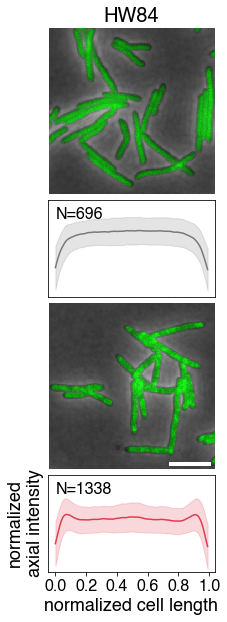

In [129]:
fig=plt.figure(figsize=(3,10))
grids = gs(16,1,hspace=0.2)
s = 'HW84'
ss = '/Volumes/JZSSD_temp/202212_Harry_flow/ClpC1_loc/20190823/{}'.format(s)
subset1 = strain_df[(strain_df['Strain']==ss)&(strain_df['Rapa']=='-')].copy()
subset2 = strain_df[(strain_df['Strain']==ss)&(strain_df['Rapa']=='+')].copy()

colors = [np.array([121,121,121])/255,np.array([225,60,80])/255]
#for i,s in enumerate(strain_df['Strain'].unique()):

ax1 = fig.add_subplot(grids[:5,0])
ax2 = fig.add_subplot(grids[5:8,0])
ax3 = fig.add_subplot(grids[8:13,0])
ax4 = fig.add_subplot(grids[13:,0])

v1 = np.vstack(subset1['$midline_profiles'].values)
mean_v1 = np.mean(v1,axis=0)
std_v1 = np.std(v1,axis=0)

v2 = np.vstack(subset2['$midline_profiles'].values)
mean_v2 = np.mean(v2,axis=0)
std_v2 = np.std(v2,axis=0)


ax2.plot(mean_v1,color=colors[0])
ax2.fill_between(np.arange(len(mean_v1)),mean_v1-std_v1,mean_v1+std_v1,color=colors[0],alpha=0.2)
ax2.set_ylim(0.2,1)
ax2.set_xticks([])
ax2.set_yticks([0.2,1])


ax4.plot(mean_v2,color=colors[1])
ax4.fill_between(np.arange(len(mean_v2)),mean_v2-std_v2,mean_v2+std_v2,color=colors[1],alpha=0.2)
ax4.set_ylim(0.2,1)
ax4.set_yticks([0.2,1])

ax2.set_yticks([])
ax4.set_yticks([])
x1=microshow(images=clips['{}{}'.format(s,'-')], 
            fig_scaling=5,
            cmaps=['pure_green','gist_gray'],
            limits=[[800,3000],#[1500,5000],
                    [2000,30000]],
            unit='um', 
            scalebar_size_in_units=0, 
            scalebar_unit_per_pix=0.065, 
            scalebar_font_size=None,
            label_font_size=None,ax=ax1)

x2=microshow(images=clips['{}{}'.format(s,'+')], 
            fig_scaling=5,
            cmaps=['pure_green','gist_gray'],
            limits=[[800,3200],#[1500,5000],
                    [2000,30000]],
            unit='um', 
            scalebar_size_in_units=5, 
            scalebar_unit_per_pix=0.065, 
            scalebar_font_size=None,
            label_font_size=None,ax=ax3)
ax2.text(0.05,0.8,'N={}'.format(len(subset1)),transform=ax2.transAxes,fontsize=16,fontname='Helvetica')
ax4.text(0.05,0.8,'N={}'.format(len(subset2)),transform=ax4.transAxes,fontsize=16,fontname='Helvetica')
ax1.set_title(s,fontsize=20,fontname='Helvetica')
ax4.set_xticks([0,20,40,60,80,100])
ax4.set_xticklabels(np.array([0,20,40,60,80,100])/100,fontsize=16,fontname='Helvetica')
ax4.set_xlabel('normalized cell length',fontsize=18,fontname='Helvetica')
ax4.set_ylabel('normalized\naxial intensity',fontsize=18,fontname='Helvetica')
plt.savefig('/Volumes/JZSSD_temp/202212_Harry_flow/ClpC1_loc/{}.svg'.format(s),bbox_inches='tight')